In [1]:
import numpy as np
import sys, os
import matplotlib.pyplot as plt
sys.path.append(os.path.realpath('..'))
import pandas as pd

from mgc.independence import Dcorr, HHG
from mgc.ksample import KSample
from mgc.sims import spiral, rot_2samp

In [2]:
N = 20

tests = [
    HHG,
    Dcorr,
    KSample,
]

In [3]:
for i in range(N):
    x, y = spiral(1000, 1, noise=True)
    sim = np.hstack([x, y])
    np.savetxt('../benchmarks/same_stat/indep/{}.csv'.format(i+1), sim, delimiter=',')
    sim1, sim2 = rot_2samp(spiral, 200, 1, noise=True)
    np.savetxt('../benchmarks/same_stat/ksample/sim1_{}.csv'.format(i+1), sim, delimiter=',')
    np.savetxt('../benchmarks/same_stat/ksample/sim2_{}.csv'.format(i+1), sim, delimiter=',')

In [4]:
for test in tests:
    stats = []
    for i in range(N):
        if test.__name__ == "KSample":
            sim1 = np.genfromtxt('../benchmarks/same_stat/ksample/sim1_{}.csv'.format(i+1), delimiter=',')
            sim2 = np.genfromtxt('../benchmarks/same_stat/ksample/sim2_{}.csv'.format(i+1), delimiter=',')
            stat = test(indep_test="Hsic", bias=True)._statistic(sim1, sim2)
        else:
            sim = np.genfromtxt('../benchmarks/same_stat/indep/{}.csv'.format(i+1), delimiter=',')
            x, y = np.hsplit(sim, 2)
            stat = test()._statistic(x, y)
        stats.append(stat)
    np.savetxt('../benchmarks/same_stat/{}.csv'.format(test.__name__), stats, delimiter=',')

In [8]:
import seaborn as sns
sns.set(color_codes=True, style='white', context='talk', font_scale=2)
PALETTE = sns.color_palette("Set1")
sns.set_palette(PALETTE[3:])

In [22]:
FONTSIZE = 30

def plot_stats():
    fig = plt.figure(figsize=(20,5))
    
    test_names = [
        "Dcorr",
        "MMD",
        "HHG"
    ]
    
    data = np.zeros((N, len(test_names)))
    for i in range(len(test_names)):
        if test_names[i] == "MMD":
            mgc_stat = np.genfromtxt('../benchmarks/same_stat/KSample.csv', delimiter=',')
            r_stat = np.genfromtxt('../benchmarks/same_stat/RMMD.csv', delimiter=',')
            mgc_stat *= 2 * 0.05 / (1000 * 2) # exact equivalence stat correction
        else:
            mgc_stat = np.genfromtxt('../benchmarks/same_stat/{}.csv'.format(test_names[i]), delimiter=',')
            r_stat = np.genfromtxt('../benchmarks/same_stat/R{}.csv'.format(test_names[i]), delimiter=',')
            if test_names[i] == "HHG": # Fix for large HHG stats so difference is comparable
                mgc_stat *= 1e-9
                r_stat *= 1e-9
        data[:, i] = np.abs(mgc_stat) - np.abs(r_stat)
    
    data = pd.DataFrame(data=data, columns=test_names)
    sns.violinplot(data=data, inner=None)
    sns.swarmplot(data=data, color="white", edgecolor="gray")
    plt.axhline(y = 0, color='red', linewidth=1) 
    
    #plt.yticks([-0.0005, 0, 0.0005])
    
    plt.savefig('../benchmarks/figs/same_stat.pdf', transparent=True, bbox_inches='tight')

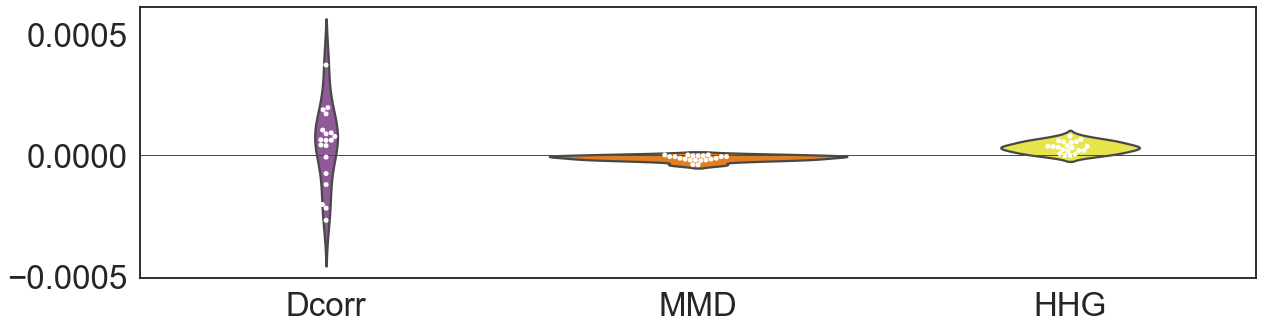

In [23]:
plot_stats()